In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
from IPython import display
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
#生成器模型
shape = (64, 64, 2)

input_img = Input(shape=(shape[0], shape[1], shape[2],))
feature1 = Conv2D(48, kernel_size=(3,3), strides=(1,1),padding='same')(input_img)
feature1 = BatchNormalization()(feature1)
feature1 = Activation('relu')(feature1)

feature2 = Conv2D(48, kernel_size=(3,3), strides=(1,1),padding='same')(feature1)
feature2 = BatchNormalization()(feature2)
feature2 = Activation('relu')(feature2)

feature12 = concatenate([feature1, feature2], 3)

feature3 = Conv2D(48, kernel_size=(3,3), strides=(1,1),padding='same')(feature12)
feature3 = BatchNormalization()(feature3)
feature3 = Activation('relu')(feature3)

feature123 = concatenate([feature12,feature3], 3)

feature4 = Conv2D(48, kernel_size=(3,3), strides=(1,1),padding='same')(feature123)
feature4 = BatchNormalization()(feature4)
feature4 = Activation('relu')(feature4)

feature1234 = concatenate([feature123,feature4], 3)

feature5 = Conv2D(48, kernel_size=(3,3), strides=(1,1),padding='same')(feature1234)
feature5 = BatchNormalization()(feature5)
feature5 = Activation('relu')(feature5)

encoder_output = concatenate([feature1234,feature5], 3)

confuse_feature = Conv2D(128, kernel_size=(3,3), strides=(1,1),padding='same')(encoder_output)
confuse_feature = BatchNormalization()(confuse_feature)
confuse_feature = Activation('relu')(confuse_feature)

confuse_feature = Conv2D(64, kernel_size=(3,3), strides=(1,1),padding='same')(confuse_feature)
confuse_feature = BatchNormalization()(confuse_feature)
confuse_feature = Activation('relu')(confuse_feature)

confuse_feature = Conv2D(32, kernel_size=(3,3), strides=(1,1),padding='same')(confuse_feature)
confuse_feature = BatchNormalization()(confuse_feature)
confuse_feature = Activation('relu')(confuse_feature)

confuse_feature = Conv2D(16, kernel_size=(3,3), strides=(1,1),padding='same')(confuse_feature)
confuse_feature = BatchNormalization()(confuse_feature)
confuse_feature = Activation('relu')(confuse_feature)

confuse_feature = Conv2D(1, kernel_size=(3,3), strides=(1,1),padding='same')(confuse_feature)
confuse_feature = BatchNormalization()(confuse_feature)
confuse_img = Activation('tanh')(confuse_feature)

generator = Model(inputs=input_img, outputs=confuse_img)
# generator.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae'])
# generator.summary()

2022-10-28 17:24:15.835251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 17:24:16.486290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:da:00.0, compute capability: 8.6


In [3]:
#这里是马尔可夫判别器（PatchGAN）的模型
def re_scalar(scalar):
    import tensorflow as tf
    x0,x1,x2,x3 = tf.split(scalar, 4, 1)
    x = (x0+x1+x2+x3)/4.0
    x = x/2+0.5
    return x

In [4]:
#判别器模型，判定生成图像与IGS-TEC强度信息差异
confuse_img_shape = (64, 64, 1)
input_confuse_img = Input(shape=(confuse_img_shape[0], confuse_img_shape[1], confuse_img_shape[2],))
img = Conv2D(32, kernel_size=(2, 2), strides=(4, 4), padding='same')(input_confuse_img)
img = LeakyReLU(0.2)(img)

img = Conv2D(64, kernel_size=(2, 2), strides=(4, 4), padding='same')(img)
img = BatchNormalization()(img)
img = LeakyReLU(0.2)(img)

img = Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding='same')(img)
img = BatchNormalization()(img)
img = LeakyReLU(0.2)(img)

img = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='same')(img)
scalar = Activation('tanh')(img)
scalar = Flatten()(scalar)
scalar = Lambda(re_scalar)(scalar)

Discriminator_IGS = Model(inputs=input_confuse_img, outputs=scalar)
# Discriminator_IGS.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae'])
Discriminator_IGS.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          8256      
                                                                 
 batch_normalization_10 (Bat  (None, 4, 4, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                           

In [5]:
#判别器模型，为了保持结构的稳定性，两个判别器结构相同
#判定生成图像与MIT-TEC的梯度信息差异
confuse_img_shape = (64, 64, 1)
input_confuse_img = Input(shape=(confuse_img_shape[0], confuse_img_shape[1], confuse_img_shape[2],))

img = Conv2D(32, kernel_size=(2, 2), strides=(4, 4), padding='same')(input_confuse_img)
img = LeakyReLU(0.2)(img)

img = Conv2D(64, kernel_size=(2, 2), strides=(4, 4), padding='same')(img)
img = BatchNormalization()(img)
img = LeakyReLU(0.2)(img)

img = Conv2D(128, kernel_size=(2, 2), strides=(2, 2), padding='same')(img)
img = BatchNormalization()(img)
img = LeakyReLU(0.2)(img)

img = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='same')(img)
scalar = Activation('tanh')(img)
scalar = Flatten()(scalar)
scalar = Lambda(re_scalar)(scalar)

Discriminator_MIT = Model(inputs=input_confuse_img, outputs=scalar)
# Discriminator_MIT.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae'])
Discriminator_MIT.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 32)        160       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 64)          8256      
                                                                 
 batch_normalization_12 (Bat  (None, 4, 4, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                           

In [6]:
#由于我们需要分别训练两个网络，判别器和生成器的优化器是不同的。
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.SGD(0.0002)
# generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002, epsilon=1e-5, decay=0.2)
# discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.0002, decay=0.9)
#sgd = SGD(lr=learning_rate, decay=learning_rate/nb_epoch, momentum=0.9, nesterov=True)

In [7]:
from LOSS import SSIM_LOSS, L1_LOSS, Fro_LOSS, _tf_fspecial_gauss, grad
#从LOSS文件中导入各种需要的约束、损失

In [8]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
# 这里的训练方式和网上大部分的方法不同，这里好像是tf1早期的写法
@tf.function
def train_step(images):
    
    IGS_picture = tf.reshape(images[:,:,:,0], [BATCH_SIZE,64,64,1])
    MIT_picture = tf.reshape(images[:,:,:,1], [BATCH_SIZE,64,64,1])
    
    with tf.GradientTape() as gen_tape0,tf.GradientTape() as gen_tape1,tf.GradientTape() as disc_tape0,tf.GradientTape() as disc_tape1:
        generated_images = generator(images , training=True)
        #生成这一批次的噪声图片（随机图片）
        real_IGS = Discriminator_IGS(IGS_picture, training=True)
        #将原来的图片扔进鉴别器，作为真实的输出
        fake_IGS = Discriminator_IGS(generated_images, training=True)
        #将自己生成的图片（噪声图片）也扔进去作为假的输出
        real_MIT = Discriminator_MIT(MIT_picture, training=True)
        #将原来的图片扔进鉴别器，作为真实的输出
        fake_MIT = Discriminator_MIT(generated_images, training=True)
        #将自己生成的图片（噪声图片）也扔进去作为假的输出

        #计算生成器的损失函数
        eps = 1e-8
        G_loss_GAN_D1 = -tf.reduce_mean(tf.math.log(fake_IGS + eps))
        G_loss_GAN_D2 = -tf.reduce_mean(tf.math.log(fake_MIT + eps))
        G_loss_GAN = G_loss_GAN_D1 + G_loss_GAN_D2

        LOSS_IGS = Fro_LOSS(generated_images - IGS_picture)
        #使用Frobenius范数来约束融合而图像的强度信息
        LOSS_MIT = L1_LOSS(grad(generated_images) - grad(MIT_picture))
        #使用L1范数来约束融合而图像的梯度信息
        G_loss_norm = LOSS_IGS + 3 * LOSS_MIT  #1.2，参数可变
        G_loss = G_loss_GAN + 0.8 * G_loss_norm  #0.8，参数可变

        # Loss for IGS_disc_loss
        D1_loss_real = -tf.reduce_mean(tf.math.log(real_IGS + eps))
        D1_loss_fake = -tf.reduce_mean(tf.math.log(1. - fake_IGS + eps))
        IGS_disc_loss = D1_loss_fake + D1_loss_real

        # Loss for MIT_disc_loss
        D2_loss_real = -tf.reduce_mean(tf.math.log(real_MIT + eps))
        D2_loss_fake = -tf.reduce_mean(tf.math.log(1. - fake_MIT + eps))
        MIT_disc_loss = D2_loss_fake + D2_loss_real
    
    gradients_of_generator0 = gen_tape0.gradient(G_loss_GAN, generator.trainable_variables)
    gradients_of_generator1 = gen_tape1.gradient(G_loss, generator.trainable_variables)
    gradients_of_disIGS = disc_tape0.gradient(IGS_disc_loss, Discriminator_IGS.trainable_variables)
    gradients_of_disMIT = disc_tape1.gradient(MIT_disc_loss, Discriminator_MIT.trainable_variables)
    #计算损失的梯度

    generator_optimizer.apply_gradients(zip(gradients_of_generator0, generator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator1, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disIGS, Discriminator_IGS.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disMIT, Discriminator_MIT.trainable_variables))
    #通过梯度来优化生成器和鉴别器的损失（性能）

In [9]:
def train(dataset, epochs, some_test):
    for epoch in range(epochs):
    #训练次数
        start = time.time()#返回时间

        for image_batch in dataset:
            train_step(image_batch)
        #print(train_step.shape)
        #这一步应该是计算和优化网络
        #image_batch.shape=(100, 64, 64, 2),将这些切片放在train_step里
        #这个子循环结束时意味着所有的图片完成了第一次的训练
        
        # 继续进行时为 GIF 生成图像
        display.clear_output(wait=True)
        #清除掉上一次画出来的图像
        generate_and_save_images(generator,
                                 epoch + 1,
                                 some_test)
        #注意，这个函数相当于predict
        #将这次循环已经训练好的生成网络送入这个画图函数
        #它这里将（16，100）的噪声图片输入了进去，这里其实就是从无到有的精髓
        #直接从噪声到类真实的图片

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 最后一个 epoch 结束后生成图片
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             some_test)

In [10]:
########生成与保存图片############
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 100 , cmap='jet')
        plt.axis('off')

    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [11]:
import numpy as np
IGS_data = np.load('IGS_data11_17.npy')
nochange_MIT = np.load('MIT_data11_17.npy')
MIT_data = np.load('pre_MIT.npy')   ###这个东西已经是归一化了

stock = np.abs(IGS_data)<=999

IGS_data = IGS_data  * stock /100
nochange_MIT = nochange_MIT/100

print(IGS_data.shape)
print(MIT_data.shape)

(61368, 64, 64, 1)
(61368, 64, 64, 1)


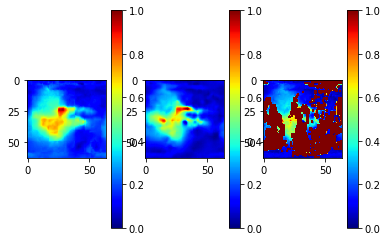

In [12]:
import matplotlib
import matplotlib.pyplot as plt

#第二个图其实就是门控卷积对MIT-TEC产生的修复，可以和原来的MIT-TEC（第三张图）进行对比
n = 7290
plt.subplot(131)
plt.imshow(IGS_data[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(132)
plt.imshow(MIT_data[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(133)
plt.imshow(nochange_MIT[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.show()

In [13]:
#将数据进行拼接，并作为输入
train_images = np.concatenate((IGS_data,MIT_data),axis=-1)

In [14]:
BUFFER_SIZE = 61368
BATCH_SIZE = 24

# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

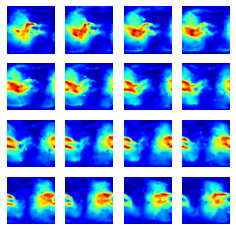

CPU times: user 1min 21s, sys: 5.3 s, total: 1min 26s
Wall time: 1min 47s


In [50]:
%%time
import time
EPOCHS = 1
train(train_dataset, EPOCHS,train_images[7290:7290+16])


In [51]:
#融合图像
predictions = generator.predict(train_images)

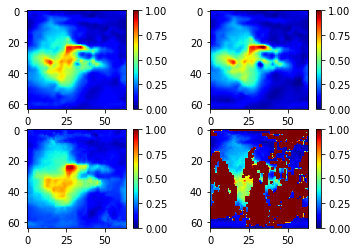

In [52]:
n = 7290
plt.subplot(221)
plt.imshow(predictions[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(222)
plt.imshow(MIT_data[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(223)
plt.imshow(IGS_data[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(224)
plt.imshow(nochange_MIT[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.show()

In [53]:
# generator.save('generator.h5')
# Discriminator_IGS.save('Discriminator_IGS.h5')
# Discriminator_MIT.save('Discriminator_MIT.h5')
# # #存了一次4.02

In [54]:
# np.save('confusion',predictions*100)